<a href="https://colab.research.google.com/github/colivarese/MNIST-Digit-Generator/blob/main/GAN_Digit_Generation_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Digit Generation using a Generative Adversarial Network

Generative Adversarial Networks (GANs) are a special kind of neural network model, where to networks "compete" against each other where one tries to fool the other by generating artificial inputs along with real ones and the other network tries to detect the fake ones from the real ones. <br>
After training the generative network will be used to create articial samples realistic enough to fool a discriminative network.
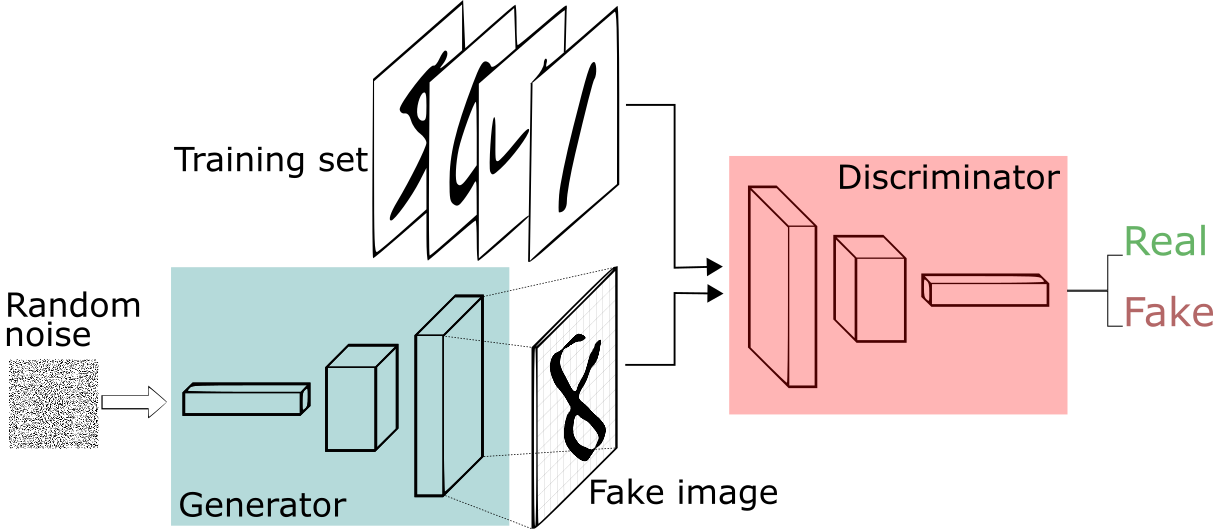

# Let's build a GAN model to generate digits similar to the ones on the MNIST dataset using TensorFlow.

## Import dependencies

In [ ]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
%matplotlib inline

Let's create a function to noralize each input to be within an invertal of 0-1. <br>
And load the data from the keras.datasets

In [ ]:
def normalize(X):
    X = X.reshape(len(X), 784)
    X = X.astype('float32')/255
    return X

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = normalize(X_train)

11493376/11490434 [==============================] - 0s 0us/step


# Design the generative network.

In [ ]:
input_dim = 100
np.random.seed(42)
optimizer = Adam(lr=0.0002, beta_1=0.5)

gen = Sequential()
gen.add(Dense(256, input_dim=input_dim))
gen.add(LeakyReLU(alpha=0.2))
gen.add(BatchNormalization())
gen.add(Dense(512))
gen.add(LeakyReLU(alpha=0.2))
gen.add(BatchNormalization())
gen.add(Dense(1024))
gen.add(LeakyReLU(alpha=0.2))
gen.add(BatchNormalization())
gen.add(Dense(784, activation='sigmoid'))
gen.compile(loss='binary_crossentropy', 
            optimizer=optimizer)

# Design the Discriminative Network.

In [ ]:
dsc = Sequential()
dsc.add(Dense(1024, input_dim=784))
dsc.add(LeakyReLU(alpha=0.2))
dsc.add(Dropout(0.3))
dsc.add(Dense(512))
dsc.add(LeakyReLU(alpha=0.2))
dsc.add(Dropout(0.3))
dsc.add(Dense(256))
dsc.add(LeakyReLU(alpha=0.2))
dsc.add(Dropout(0.3))
dsc.add(Dense(1, activation='sigmoid'))  
dsc.compile(loss='binary_crossentropy', 
            optimizer=optimizer)

# Create a function to set the networks layers as trainable.
## And define the pipeline, we will input some noise to the generative network, an use as an output the prediction from the discriminative one.

In [ ]:
def make_trainable(dnn, flag):
    dnn.trainable = flag
    for l in dnn.layers:
        l.trainable = flag
        
make_trainable(dsc, False)
inputs = Input(shape=(input_dim, ))
hidden = gen(inputs)
output = dsc(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy',
            optimizer=optimizer)

# Let's create the function to creat from noise from a normal distribution and a function to plot each sample.

In [ ]:
def create_noise(n, z):
    return np.random.normal(0, 1, size=(n, z))

def plot_sample(n, z):
    samples = gen.predict(create_noise(n, z))
    plt.figure(figsize=(15,3))
    for i in range(n):
        plt.subplot(1, n, (i+1))
        plt.imshow(samples[i].reshape(28, 28), 
                   cmap='gray_r')
        plt.axis('off')
    plt.show()

# Train the model for 100 epochs, with a batch size of 128 (this will depend on the available memory).



1.   Take a random sample batch from the MNIST dataset.
2.   Generate the batch
3.   Generate random noise to use as a fake input.
4.   Generate an image from the noise with the generator network **gen.predict( )**
5.   Concatenate the true images with the fake ones (generator output).
6.   Generate fake labels.
7.   Set the discriminative as trainable and input to it the batch of images (real + fakes)
8.   Generate random samples from noise to train the generative.
9.   Save the losses.
10.  Every 10th epoch, show the outputs from the generator.



Epoch 0


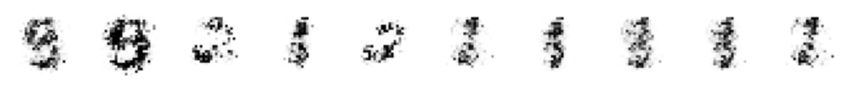

Epoch 10


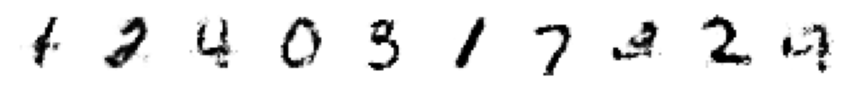

Epoch 20


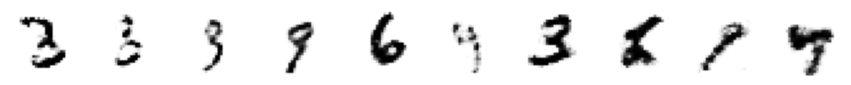

Epoch 30


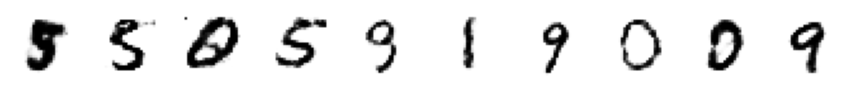

Epoch 40


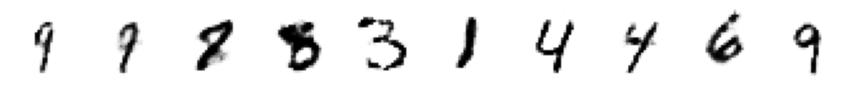

Epoch 50


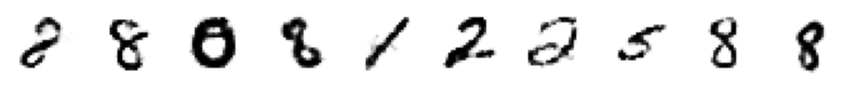

Epoch 60


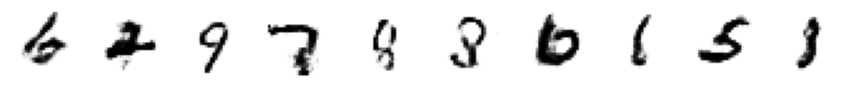

Epoch 70


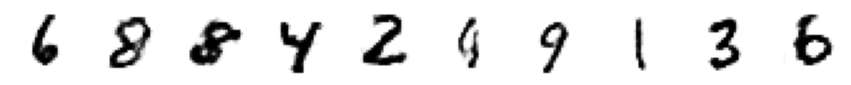

Epoch 80


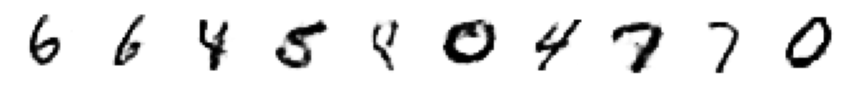

Epoch 90


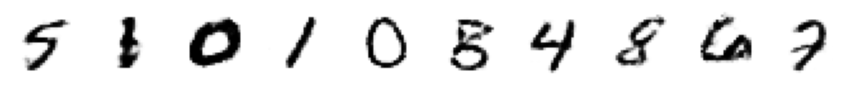

In [ ]:
epochs = 100
batch_size = 128
batch_no = int(len(X_train) / batch_size)
gen_errors, dsc_errors = (list(), list())

for i in range(0, epochs):
    for j in range(batch_no): 
      
        # Drawing a random sample of the training set
        rand_sample = np.random.randint(0, len(X_train), size=batch_size)
        image_batch = X_train[rand_sample]
        
        # Creating noisy inputs for the generator
        input_noise = create_noise(batch_size, input_dim)

        # Generating fake images from the noisy input
        generated_images = gen.predict(input_noise)
        X = np.concatenate((image_batch, generated_images))
        
        # Creating somehow noisy labels
        y = np.concatenate([[0.9]*batch_size, [0.0]*batch_size])

        # Training discriminator to distinguish fakes from real ones
        make_trainable(dsc, True)
        dsc_loss = dsc.train_on_batch(X, y)
        make_trainable(dsc, False)

        # Trainining generating fakes
        input_noise = create_noise(batch_size, input_dim)
        fakes = np.ones(batch_size)
        for _ in range(4):
          gen_loss = gan.train_on_batch(input_noise, fakes)

    # Recording the losses
    gen_errors.append(gen_loss)
    dsc_errors.append(dsc_loss)

    # Showing intermediate results
    if i % 10 == 0:
      print("Epoch %i" % i)
      plot_sample(10, input_dim)

# It can be appreciated that on each epoch the generate digits are being more realistic, great! 😃

# Let's take a look at the losses.

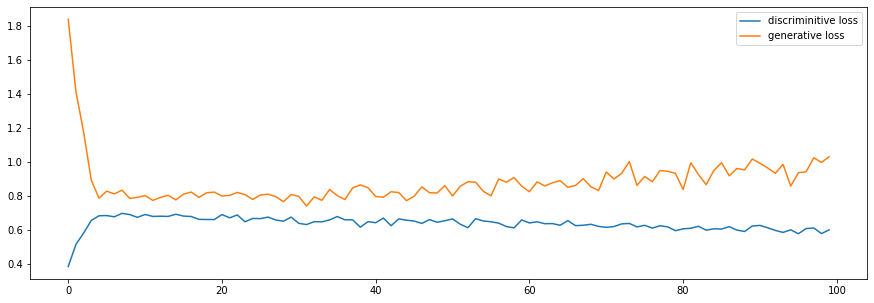

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(dsc_errors, label='discriminitive loss')
plt.plot(gen_errors, label='generative loss')
plt.legend()
plt.show()

### It can be seen that the losses are having an opposite behaviour, the generative one is getting lower on each epoch, meaning that it is generating more realistic images, while the discriminative loss goes up, while the generative is still making unrealistic images, but then starts to to down, because it is being unabled to discriminate the real from the fake images.